In [1]:
import sklearn
import numpy as np
import tensorflow as tf

### 1. Getting the data ready

Fetch the dataset.

In [2]:
from sklearn.datasets import fetch_california_housing
data=fetch_california_housing()
m,n =data.data.shape
print("Number of datapoints: {}, Number of features: {}".format(m,n))

Number of datapoints: 20640, Number of features: 8


Since we are going to use gradient descent, we need to normalize the features. We will use [StandardScalar](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) for this.

In [3]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_data=scaler.fit_transform(data.data)

We well merge the bias into the feature matrix by adding an extra column of 1's. Also, we put the values for `y` in `target_date`

In [4]:
data_with_bias=np.c_[np.ones((m,1)),scaled_data]
data_target=np.array(data.target.reshape(-1,1))

## 2. Setting up placeholders and variables
Now this is important, since we are going to be using mini-batch gradient descent ([this](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/) is a good explanation if you do not know what that is), we will not be feeding in the complete `X` and `y` on every step of gradient descent. Instead, we will be feeding in a portion of `X` (some rows,all columns) and the corresponding portion of `y` for computing the gradient at every step. Call this step as an **iteration**. Hence there will be several of such iterations before the entire `X` and `y` is processed once. When the entire `X` and `y` is seen once by the trainig algorithm we say that it has completed one **epoch**. 

So at each iteration of each epoch, we need to feed in a chunck of `X` and `y` to the training algorithm. We can do this by using placeholders as shown below. At this point one must wonder if we need the placeholder. We can achieve the same using a `tensorflow.Variable`. Indeed, technically we can do that but to be clear on the  philosophical level, we will use placeholders. There are quite a few discussions on this question on [StackOverflow](https://stackoverflow.com/questions/36693740/whats-the-difference-between-tf-placeholder-and-tf-variable). 

In [5]:
# create placeholders for X and y
X=tf.placeholder(tf.float32,shape=(None,n+1),name="X")
y=tf.placeholder(tf.float32,shape=(None,1),name="y")
# create theta as a variable
theta=tf.Variable(tf.random_uniform([n+1,1],-1,1),dtype=tf.float32,name="theta")

Setup the optimization problem by defining the Mean Square Error as the cost.

In [6]:
# define the MSE
y_pred=tf.matmul(X,theta,name="pred")
error=y-y_pred
mse=tf.reduce_mean(tf.square(error),name="mse")

We need a way to fetch the appropriate chunk of `X` and `y` at every iteration and for that we define the following function.

In [7]:
# function to fetch batches during the loop
def fetch_batch(epoch,batch_index,batch_size,X_full,y_full):
    starting_index=batch_index*batch_size # 0-based
    X_batch=X_full[starting_index:batch_size-1,:]
    y_batch=y_full[starting_index:batch_size-1,:]
    return X_batch,y_batch

We use the awesome **Autodiff** of tensorflow to define the gradient *op*. 

In [8]:
grad=tf.gradients(mse,[theta])[0]

This defines the *op* as the gradient of MSE with respect to theta. We need the indexing of `[0]` because the `gradients()` returns a list which in this case will have only one entry, ie., d(mse)/d(theta).

### 3. Time to run our experiments

We will run the training with different mini-batch sizes and learning rates and see what happens to the convergence.

In [9]:
# batch parameters
batch_sizes=[m,10000,4000,1000,500,100]
n_batches=[int(np.ceil(m/batch_size)) for batch_size in batch_sizes]
learning_rates=[0.1,0.01,0.001]
n_epochs=10000
print("Number of batches and corresponding batch sizes: {} and {}".format(n_batches,batch_sizes))

Number of batches and corresponding batch sizes: [1, 3, 6, 21, 42, 207] and [20640, 10000, 4000, 1000, 500, 100]


Note, that when batch size is m, the mini-batch gradient descent becomes the good old batch gradient descent.

In order to visualize the results using TensorBoard, we need to log the MSE after some intervals during training. If we log the MSE at every iteration, the trainig will become extremely slow for small batch sizes. Hence we will log the MSE at regular intervals with the interval length depending on the batch size.

In [10]:
number_of_logging_points=1000
number_of_iterations=[n_epochs*n_batch for n_batch in n_batches]
logging_intervals=[int(np.ceil(n_iterations/number_of_logging_points)) for n_iterations in number_of_iterations]

Set up the summary logging *op* and the directory to log into. 

In [11]:
mse_summary=tf.summary.scalar("MSE",mse)
root_log_dir="linear_reg_mini_batch_log"

In [12]:
# trainig info
for index,batch_size in enumerate(batch_sizes):
    for learning_rate in learning_rates:
        print("Starting with batch_size, learning_rate : {},{}".format(batch_size,learning_rate))
        logdir="{}/bs_lr_{}_{}_".format(root_log_dir,batch_size,learning_rate)
        with tf.summary.FileWriter(logdir,tf.get_default_graph()) as file_writer:
            tf_learning_rate=tf.constant(learning_rate,dtype=tf.float32,name="eta")
            training_op=tf.assign(theta,theta-tf.scalar_mul(tf_learning_rate,grad))

            # optimization loop
            init=tf.global_variables_initializer()
            with tf.Session() as sess:
                sess.run(init)
                for epoch in range(n_epochs):
                    for batch_index in range(n_batches[index]):
                        X_batch,y_batch=fetch_batch(epoch,batch_index,batch_size,data_with_bias,data_target)
                        sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
                        iteration_number=epoch*n_batches[index] + batch_index
                        # log if its time
                        if iteration_number%logging_intervals[index]==0:
                            summary_str = mse_summary.eval(feed_dict={X:data_with_bias, y: data_target})
                            #print("Summary at iteration {} is {}".format(iteration_number,summary_str))
                            file_writer.add_summary(summary_str,iteration_number)
                best_theta=theta.eval()
                print("Last theta for batch_size = {} and learning_rate = {} is {}".format(batch_size,learning_rate,best_theta))
    

Starting with batch_size, learning_rate : 20640,0.1
Last theta for batch_size = 20640 and learning_rate = 0.1 is [[ 2.0685394 ]
 [ 0.8296084 ]
 [ 0.11876322]
 [-0.2654881 ]
 [ 0.30567175]
 [-0.00450175]
 [-0.03932488]
 [-0.90001875]
 [-0.8706466 ]]
Starting with batch_size, learning_rate : 20640,0.01
Last theta for batch_size = 20640 and learning_rate = 0.01 is [[ 2.0685456 ]
 [ 0.8296293 ]
 [ 0.11876663]
 [-0.26552728]
 [ 0.30570385]
 [-0.00450078]
 [-0.03932568]
 [-0.8999754 ]
 [-0.8706057 ]]
Starting with batch_size, learning_rate : 20640,0.001
Last theta for batch_size = 20640 and learning_rate = 0.001 is [[ 2.0684962 ]
 [ 0.87597966]
 [ 0.14852975]
 [-0.31368488]
 [ 0.32818463]
 [ 0.00572688]
 [-0.04283285]
 [-0.63938254]
 [-0.6135134 ]]
Starting with batch_size, learning_rate : 10000,0.1
Last theta for batch_size = 10000 and learning_rate = 0.1 is [[ 2.0568504 ]
 [ 0.8582064 ]
 [ 0.06467796]
 [-0.2956867 ]
 [ 0.31660813]
 [-0.00608491]
 [-0.07521318]
 [-0.9474076 ]
 [-0.78547466]

### 4. Visualization of the results

You can see the logged values of MSE using TensorBoard using `$ tensorboard --logdir path_to_root_log_dir`. Unfortunately there is no way to export the graphs as images from tensorboard. However, it does let you export the data as csv file, which I have used to create these graphs.

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
dir_for_csv="/Users/dhruvesh/Downloads"
Dfs=[[pd.read_csv("/Users/dhruvesh/Downloads/run_bs_lr_{}_{}_-tag-MSE.csv".format(batch_size,learning_rate))
              for learning_rate in learning_rates]
              for batch_size in batch_sizes]
labels=[["Learning_r :{}".format(learning_rate)
              for learning_rate in learning_rates]
              for batch_size in batch_sizes]

In [53]:
def plot_for_batch_s(Dfs,labels,batch_number,learning_rates,axis):
    for i,learning_rate in enumerate(learning_rates):
        axis.plot(Dfs[batch_number][i]['Step'],Dfs[batch_number][i]['Value'],label="Learning_r = {}".format(learning_rate))
        #plt.ylim([0.4,2.5])
        axis.set_title("Batch size : {}".format(batch_sizes[batch_number]))
        axis.legend()

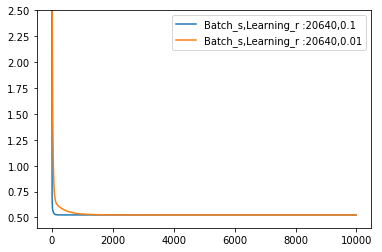

In [54]:
plt.plot(Dfs[0][0]['Step'],Dfs[0][0]['Value'],label=labels[0][0])
plt.plot(Dfs[0][1]['Step'],Dfs[0][1]['Value'],label=labels[0][1])
plt.ylim([0.4,2.5])
plt.legend()

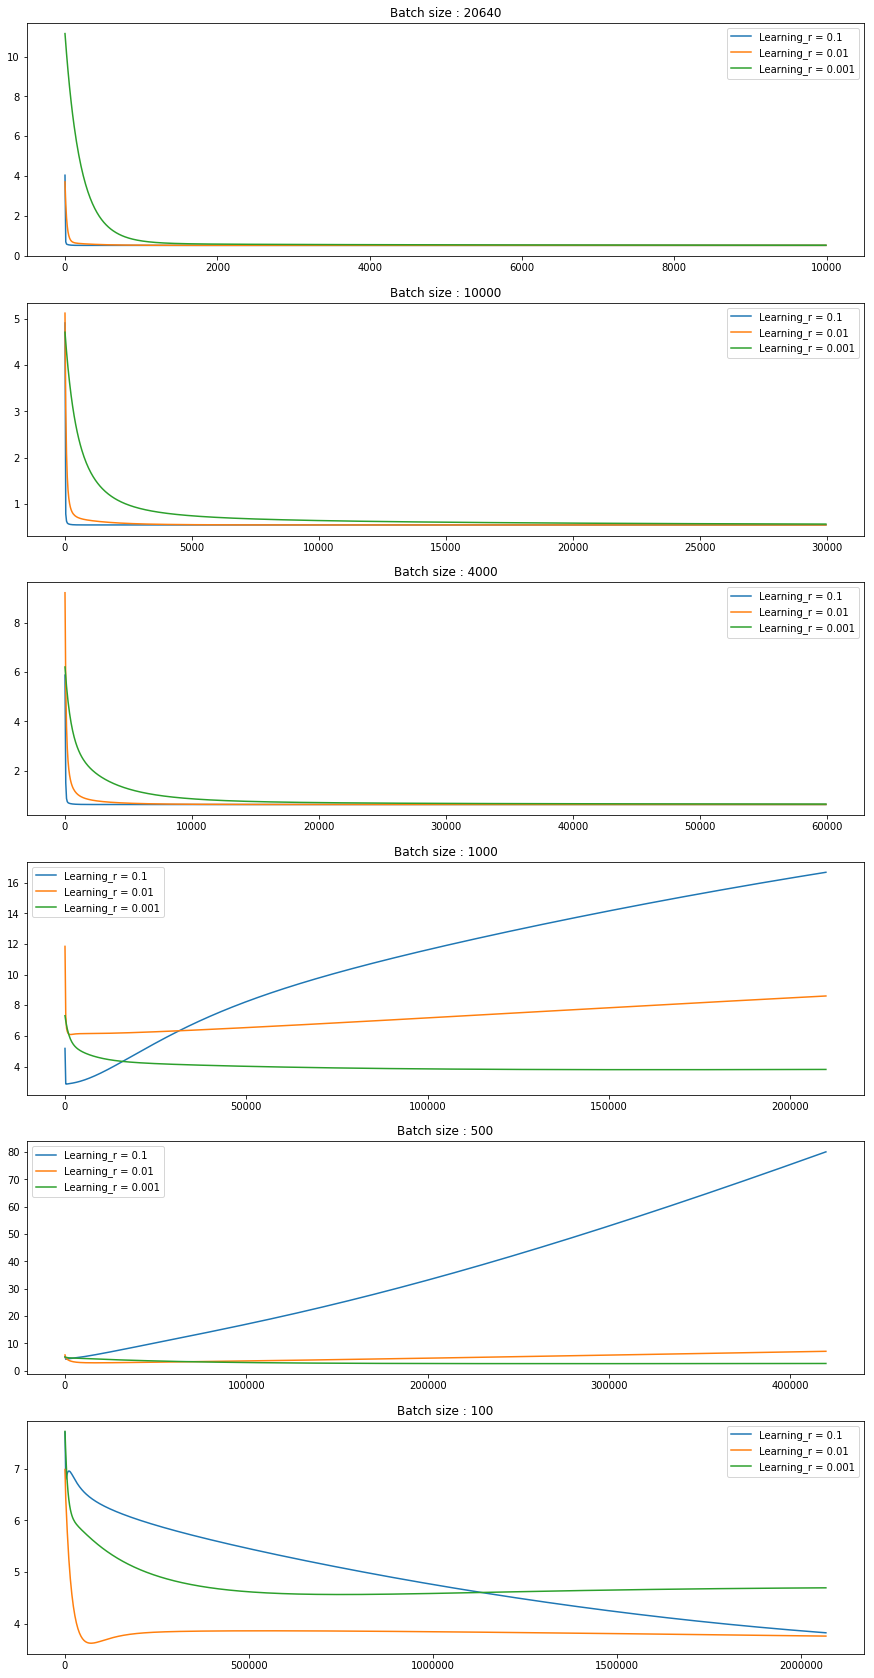

In [55]:
fig,axes=plt.subplots(6,figsize=(15,30))
for batch_number,batch_s in enumerate(batch_sizes):
    plot_for_batch_s(Dfs,labels,batch_number,learning_rates,axes[batch_number])

As we reduce the mini-batch size, the training algorithm finds it difficult to converge. Infact, it starts to diverge (as shown for batch sizes of 1000 and less). While reducing the learning rate stabilizes the training and does not let it diverge, it slows down the training significantly. 

Then why not use the straitforward batch gradient instead of mini-batch gradient and be done with it ? Well, for linear regression, the cost function is convex and that is why the normal batch gradient descent works perfectly. The true usefulness of mini-batch gradient descent will be seen when the cost function is more complex and is now convex.